# **Introduction**

สวัสดีครับ นี้เป็นการส่ง Final Project ของ CS434

ทุกๆ วันนี้ 2 พันกว่าล้านแอพให้ผู้ใชได้ดาวโหลด และกว่า 2 ล้านกว่าแอพให้โหลดใน
Google Play Store. แอพพวกนี้ได้มีช่วยในการใช้ชีวติของพวกเราจนถึงทุกวันนี้

วันนี้ผมจะมาลองศึกษาเกี่ยวกับการแนะนำ App ตามคำค้นหาในแต่ละรูปแบบ

# **Table of Contents**

-   [Importing Libraries](#importing)
-   [Importing Dataset](#datasets)
-   [Basic Data Exploration](#basic_understanding)
-   [Data Cleaning](#data_cleaning)
-   [Exploratory Data Analysis](#eda)
-   [Feature Engineering](#feature_engineering)
-   [References](#references)


<a id='importing'></a>

## **Importing libraies**


In [1274]:
# imports
# ref: https://www.kaggle.com/nandalald/android-app-recommendation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
import pandas as pd
import numpy as np
import gradio as gr
from matplotlib import pyplot as plt
import seaborn as sns
import time
plt.style.use('seaborn')


<a id='datasets' ></a>

## **Importing Dataset**


In [1275]:

file_name = "data/googleplaystore.csv"
df_temp = pd.read_csv(file_name, encoding="utf-8")


<a id='basic_understanding' ></a>

## **Basic Data Exploration**


In [1276]:
df_temp.sample(5)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
3971,UC Browser - Fast Download Private & Secure,COMMUNICATION,4.5,17712922,40M,"500,000,000+",Free,0,Teen,Communication,"August 2, 2018",12.8.5.1121,4.0 and up
1977,Hill Climb Racing,GAME,4.4,8923847,63M,"100,000,000+",Free,0,Everyone,Racing,"July 2, 2018",1.37.2,4.2 and up
9225,"TN Patta, Chitta, EC",TOOLS,4.1,633,3.8M,"100,000+",Free,0,Everyone,Tools,"October 21, 2016",6.7,2.3 and up
9013,DW Maps,TRAVEL_AND_LOCAL,3.7,35,13M,"10,000+",Free,0,Everyone,Travel & Local,"June 6, 2017",1.9,2.3.3 and up
10622,MY GULFPORT FL,PRODUCTIVITY,NaN,0,49M,50+,Free,0,Everyone,Productivity,"May 18, 2018",17.4,4.1 and up


In [1277]:

df_temp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [1278]:
# check null
df_temp.isna().sum()


App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

_จะเห็นได้ว่า rating มีข้อมูลเสียเยอะ_


<a id='data_cleaning' ></a>

## **Data Cleaning**

> เราจะใช้ข้อมูลที่จำเป็นสำหรับการใช้ข้อมูลนี้เท่านั้น  
> เช็คข้อมูล insight หลักๆ ที่อาจจะทำให้เรามีปัญหาในการใช้ข้อมูล  
> ข้อมูลที่ไม่จำเป็นเราจะนำออกไป เช่น rating, reviews บลาๆ  
>


In [1279]:
df = df_temp.copy()

# remove unuse cols
df = df.reindex(columns=['App', 'Category', 'Size',
                'Type', 'Genres', 'Price', 'Installs', 'Content Rating'])


In [1280]:
# rename col
temp_keys = {}
for i in df.columns:
    temp_keys[i] = i.lower()
df = df.rename(columns=temp_keys)


In [1281]:
df.isna().sum()
# ข้อมูลที่เสียมีน้อยมาก

app               0
category          0
size              0
type              1
genres            0
price             0
installs          0
content rating    1
dtype: int64

In [1282]:
# ลบข้อมูลที่ซ้ำๆ
df.drop_duplicates(subset='app', inplace=True, ignore_index=True)
df.shape


(9660, 8)

In [1283]:
# เราจะทำการลบข้อมูล ที่เสียหาย
df.dropna(axis=0, inplace=True)
df.isna().sum()


app               0
category          0
size              0
type              0
genres            0
price             0
installs          0
content rating    0
dtype: int64

_ข้อมูลที่เสียหายหมดแล้วว_

#### เช็คแต่ละตารางที่อาจจะมีปัญหา


In [1284]:
df.groupby(['content rating'])['content rating'].count()


content rating
Adults only 18+       3
Everyone           7903
Everyone 10+        321
Mature 17+          393
Teen               1036
Unrated               2
Name: content rating, dtype: int64

_จากข้อมูลชุดนี้ Unrate น่าจะหมายถึง everyone_

#### ทำการเปลี่ยนข้อมูล


In [1285]:
df.loc[df['content rating'] == 'Unrated', ['content rating']] = 'Everyone'

df.groupby(['content rating'])['content rating'].count()


content rating
Adults only 18+       3
Everyone           7905
Everyone 10+        321
Mature 17+          393
Teen               1036
Name: content rating, dtype: int64

_ข้อมูลถูกเปลี่ยนแล้วเย้_


In [1286]:

df.groupby(['category'])['category'].count()


category
ART_AND_DESIGN           64
AUTO_AND_VEHICLES        85
BEAUTY                   53
BOOKS_AND_REFERENCE     222
BUSINESS                420
COMICS                   56
COMMUNICATION           315
DATING                  171
EDUCATION               119
ENTERTAINMENT           102
EVENTS                   64
FAMILY                 1831
FINANCE                 345
FOOD_AND_DRINK          112
GAME                    959
HEALTH_AND_FITNESS      288
HOUSE_AND_HOME           74
LIBRARIES_AND_DEMO       84
LIFESTYLE               369
MAPS_AND_NAVIGATION     131
MEDICAL                 395
NEWS_AND_MAGAZINES      254
PARENTING                60
PERSONALIZATION         376
PHOTOGRAPHY             281
PRODUCTIVITY            374
SHOPPING                202
SOCIAL                  239
SPORTS                  325
TOOLS                   827
TRAVEL_AND_LOCAL        219
VIDEO_PLAYERS           163
WEATHER                  79
Name: category, dtype: int64

In [1287]:
# มาดูส่วนของ genres
df.groupby(['genres'])['genres'].count()


genres
Action                                   299
Action;Action & Adventure                 12
Adventure                                 73
Adventure;Action & Adventure               5
Adventure;Brain Games                      1
                                        ... 
Video Players & Editors                  162
Video Players & Editors;Creativity         1
Video Players & Editors;Music & Video      2
Weather                                   79
Word                                      23
Name: genres, Length: 118, dtype: int64

_จะเป็นได้ว่าบาง genres มีมา่กกว่า 1 รูปแบบ ซึ่งแบ่งด้วย ตัว semi colon_  
_เราจะแบ่งตัว genres ให้เป็นรูปแบบ ว่าตัว genres มันมีเท่าไหร่_


In [1288]:

genres = df['genres']
genres_results = {}
for gen in genres:
    for g in gen.split(';'):
        if g not in genres_results:
            genres_results[g] = 1
            continue
        genres_results[g] += 1
genres_results


{'Art & Design': 65,
 'Pretend Play': 69,
 'Creativity': 33,
 'Action & Adventure': 98,
 'Auto & Vehicles': 85,
 'Beauty': 53,
 'Books & Reference': 225,
 'Business': 420,
 'Comics': 56,
 'Communication': 316,
 'Dating': 171,
 'Education': 678,
 'Music & Video': 31,
 'Brain Games': 64,
 'Entertainment': 592,
 'Events': 64,
 'Finance': 345,
 'Food & Drink': 112,
 'Health & Fitness': 290,
 'House & Home': 74,
 'Libraries & Demo': 84,
 'Lifestyle': 370,
 'Adventure': 80,
 'Arcade': 199,
 'Casual': 225,
 'Card': 49,
 'Action': 311,
 'Strategy': 98,
 'Puzzle': 142,
 'Sports': 335,
 'Music': 22,
 'Word': 23,
 'Racing': 108,
 'Simulation': 206,
 'Board': 60,
 'Trivia': 39,
 'Role Playing': 115,
 'Educational': 102,
 'Music & Audio': 1,
 'Video Players & Editors': 165,
 'Medical': 395,
 'Social': 239,
 'Shopping': 202,
 'Photography': 281,
 'Travel & Local': 219,
 'Tools': 827,
 'Personalization': 376,
 'Productivity': 374,
 'Parenting': 60,
 'Weather': 79,
 'News & Magazines': 254,
 'Maps & N

#### เปลี่ยนขนาดให้เป็น k ทั้งหมด

In [1289]:
def convert_size(s):
    if s.replace('M', '').replace('.', '', 1).isdigit():
        size = float(s.replace('M', ''))
        return 1024 * size
    if s.replace('k', '').replace('.', '', 1).isdigit():
        return float(s.replace('k', ''))
    return 0


> จะเห็นได้ว่า size เป็น type object ต้องเปลี่ยนเป็น int  
> ซึ่งเราจะแปลกตัวเลขนี้ ให้เป็นค่า kb ทั้งหมด จะได้ใช้ได้ง่าย เมื่อมีค่าอิน
> นอกจากตัวค่า mb


In [1290]:
df['size'] = df['size'].apply(convert_size)
df['size'].sample(5)


4075     9318.4
6870        0.0
2293        0.0
9539    11264.0
6312        0.0
Name: size, dtype: float64

_จะเห็นได้ว่า installs เป็น type object ต้องเปลี่ยนเป็น int_


In [1291]:
df['installs'].sample(2)


6861        10,000+
186     10,000,000+
Name: installs, dtype: object

_ข้อมูลจะมี + ตามหลัง และ comma เราจะนำออก; และเปลี่ยนค่าเป็น int32_


In [1292]:
df['installs'] = df['installs'].str.replace(
    '+', '', regex=True).replace(',', '', regex=True).astype(int)
df['installs']


0          10000
1         500000
2        5000000
3       50000000
4         100000
          ...   
9655        5000
9656         100
9657        1000
9658        1000
9659    10000000
Name: installs, Length: 9658, dtype: int32

In [1293]:
# price จะมีสองรูปแบบคือ free กับ paid ต้องเปลี่ยนเป็น bin ถึงจะได้ง่ายต่อการทำงาน

df.loc[df['price'] != "Free", 'price'] = df.loc[df['price']
                                                != "Free", 'price'].apply(lambda x: float(x.replace('$', '')))

df.loc[df['price'] == 'Free', 'price'] = 0

df['price'].sample(5)


2683    0.00
9276    0.99
678     0.00
2246    0.00
3322    3.99
Name: price, dtype: float64

<a id='eda'></a>

## **Exploratory Data Analysis**


### ดูประรูปแบบของอายุของแต่ละประเภท

    ดูว่าแต่แอพแต่ละประเภทนั้นมีความนิยมในช่วงอายุไหน


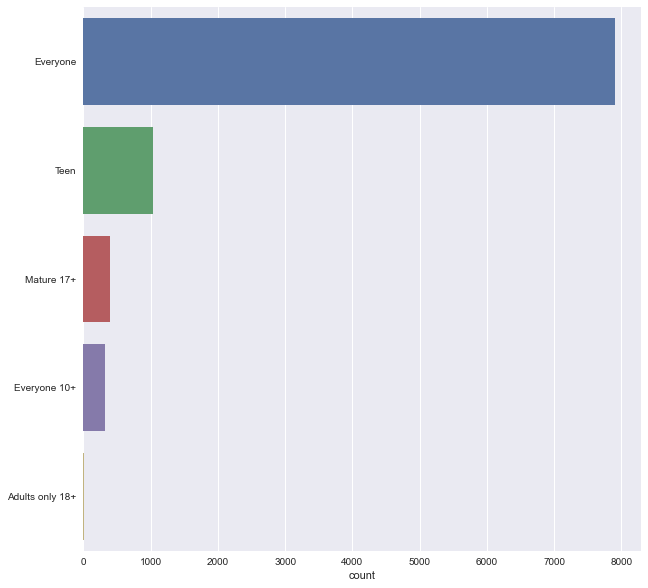

In [1294]:
plt.figure(figsize=(10, 10))
category_dict = dict(df[['content rating']].groupby(
    'content rating')['content rating'].count())
data_plot = dict(sorted(category_dict.items(),
                 key=lambda kv: kv[1], reverse=True))
data_plot = [key for key, val in data_plot.items() for _ in range(val)]
sns.countplot(y=data_plot)
plt.show()

# bar chart


*จะเห็นได้ว่า ความนิยมส่วนใหญ่นั้น จะเน้นนิยมไปทางทุกช่วงอายุคน*

### ดูความนิยมของ 20 อันดับแรกของ แต่ละหมวดหมู่

    ดูว่าแต่แอพแต่ละหมวดหมู่นั้นมีความนิยมเป็นประเภทไหนซะส่วนใหญ่


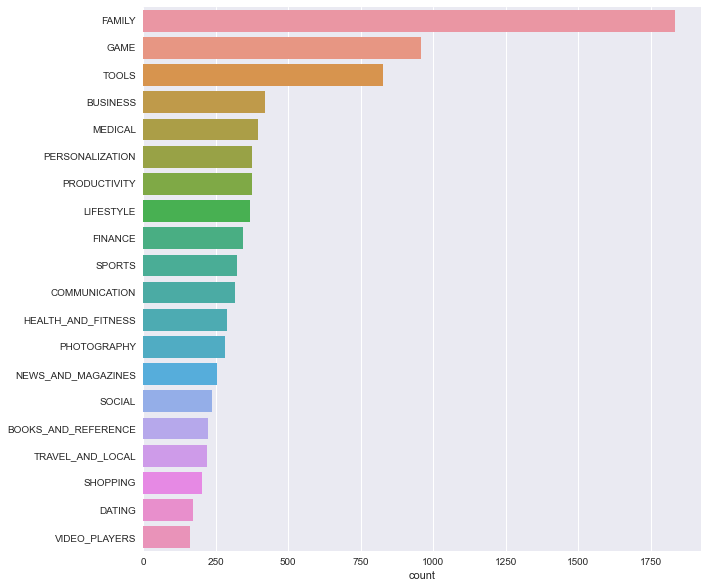

In [1295]:
plt.figure(figsize=(10, 10))
category_dict = dict(df[['category']].groupby(
    'category')['category'].count().nlargest(20))
data_plot = dict(sorted(category_dict.items(),
                 key=lambda kv: kv[1], reverse=True))
data_plot = [key for key, val in data_plot.items() for _ in range(val)]
sns.countplot(y=data_plot)
plt.show()


*แอพหมวดหมู่ FAMILY จะมีเยอะที่สุด และ ตามมาด้วย GAME ใน Google Play Store*


### ดูความนิยมของแต่ละประเภทในแต่ละแอพ

    ดูว่าแต่ละแอพนั้นนิยมประเภทแบบไหนบ้าง


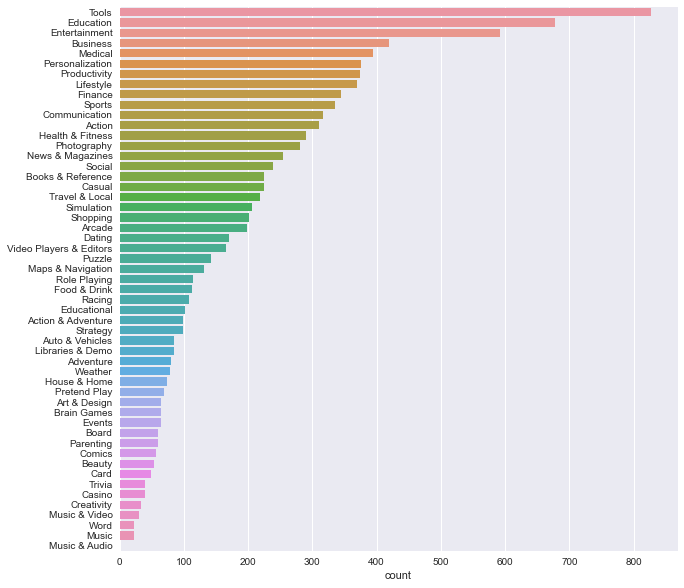

In [1296]:
# ดูความนิยมของแต่ละ tag ในแอพ
plt.figure(figsize=(10, 10))
data_plot = dict(sorted(genres_results.items(),
                 key=lambda kv: kv[1], reverse=True))
data_plot = [key for key, val in data_plot.items() for _ in range(val)]
sns.countplot(y=data_plot)
plt.show()


*แอพประเภท Tools จะมีเยอะที่สุดใน Google Play Store*


### ดูหมวดหมูแต่ละหมวดหมู่ว่า หมวดหมู่ไหนนิยมเสียเงิน

    แสดงหมวดหมูที่นิยมเสียเงิน


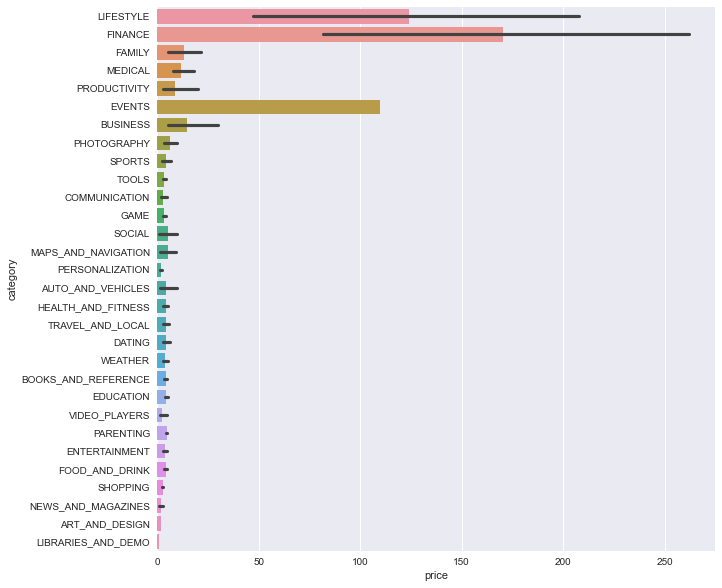

In [1297]:
plt.figure(figsize=(10, 10))
price_sort = df.loc[df.type == 'Paid', ['price', 'category']]
data_plot = dict(price_sort.sort_values(by=['price'], ascending=False))
sns.barplot(data=data_plot, x='price', y='category')
plt.show()


*จะเห็นได้ว่า หมวดหมู่ LIFT STYLE จะแพงที่สุด แต่หมวดหมู่ FINANCE
แอพส่วนใหญ่แน่นเป็นแอพเสียเงิน*


<a id='feature_engineering'></a>

## **Feature Engineering**

#### เราจะทำในเรื่องของ App Recommendation
- เราจะใช้ตัว CountVectorizer เพราะเราจะใช้ข้อมูลที่ใช้ในการค้นหาเป็นหลักๆ

In [1298]:
# เรียกใช้ตัว CountVectorizer
count_vectorizer = CountVectorizer(lowercase=True, stop_words='english')
tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')


*แต่ก่อนอื่นเราต้องจัดข้อมูลใหม่ก่อน ให้ ตัว CountVectorizer จะได้แบ่งคำง่ายๆ*

- เราจะตัดประเภทและหมวดหมู่ที่ซ้ำออก

In [1299]:
# สร้างข้อมูลของ content


def construct_content(x: str):
    join_genres = "".join(x.split(' '))
    join_category = "".join(join_genres.upper().split('_AND_'))

    results = []

    for i in join_category.split(';'):
        if i not in results:
            results.append(i)

    return ";".join(results)


describe = (df['genres'].replace(to_replace='(;|&| +)', value=' ',
            regex=True) + ";" + df['category'] + ";" + df['content rating'] + ";" + df['type']).apply(lambda x: construct_content(x))
describe.sample(5)


5780    EDUCATIONAL;FAMILY;EVERYONE;FREE
9310           PERSONALIZATION;TEEN;FREE
8448                 CARD;GAME;TEEN;FREE
6231         HEALTHFITNESS;EVERYONE;FREE
4942      EDUCATION;FAMILY;EVERYONE;FREE
dtype: object

In [1300]:
# สร้างตัว matrix สำหรับ content ที่ใช้สำหรับข้อมูลที่คล้ายๆกัน
time_start = time.time()
cosine_similarity
content_count_matrix = count_vectorizer.fit_transform(describe)
content_cosine_sim = linear_kernel(
    content_count_matrix, content_count_matrix)
content_count_matrix.shape
time_end = time.time()
print(f"Content Similarity : {round(time_end - time_start, 2)} second")


Content Similarity : 0.87 second


In [1301]:
# สร้างตัว matrix สำหรับ content ที่คล้ายแกัน โดยไม่สนว่าจ่ายเงินหรือไม่จ่าย
time_start = time.time()
type_count_matrix = tfidf_vectorizer.fit_transform((df['genres'].replace(
    to_replace='(;|&| +)', value=' ', regex=True)+';' + df['category']).apply(lambda x: construct_content(x)))
type_cosine_sim = linear_kernel(type_count_matrix, type_count_matrix)
type_count_matrix.shape
time_end = time.time()
print(f"Type Similarity : {round(time_end - time_start, 2)} second")


Type Similarity : 0.3 second


In [1302]:
# สร้างตัว matrix สำหรับ ชื่อแอพที่คล้ายๆ กีน
time_start = time.time()
name_count_matrix = tfidf_vectorizer.fit_transform(
    (df['category']+';' + df['app']))
name_cosine_sim = linear_kernel(name_count_matrix, name_count_matrix)
name_count_matrix.shape
time_end = time.time()
print(f"Name Similarity : {round(time_end - time_start, 2)} second")


Name Similarity : 0.39 second


In [1303]:
class Recommendations:
    def __init__(self, name: str, amount: int = 10):
        self.name = self.nearest_name(name)
        self.amount = amount

    def nearest_name(self, name: str):
        close = self.get_close_matches(name)
        get_sr = df['app'][df['app'].isin([name])]
        if len(get_sr) != 0:
            return get_sr.iloc[0]
        elif close:
            return close[0]
        return None

    def get_close_matches(self, name: str):
        global df
        get_sr2 = df['app'][df['app'].apply(
            lambda x: x.lower()).str.contains(name.lower())]
        if len(get_sr2) != 0:
            return get_sr2.tolist()
        return []

    def get_indices(self):
        metadata = df.reset_index()
        indices = pd.Series(metadata.index, index=metadata['app'])
        if not self.name:
            return None
        return indices[self.name]

    def get_recommendations(self, cosine_sim=content_cosine_sim):
        indice = self.get_indices()
        if not indice:
            return 'No name was near'
        sim_scores = list(enumerate(cosine_sim[indice]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:self.amount + 1]
        _indices = [i[0] for i in sim_scores]

        recs = df[['app', 'genres', 'category', 'type', 'content rating']].iloc[_indices]
        recs['match_score'] = [i[1] for i in sim_scores]
        recs['match_score'] = recs['match_score'].apply(lambda x: round(x, 4))
        recs = recs.loc[recs.app != self.name]
        return recs.loc[recs.match_score > 0, ['app', 'genres', 'category', 'type', 'content rating', 'match_score']]

    def get_app_detail(self):
        return df.loc[df['app'] == self.name, ['app', 'genres', 'category', 'type', 'content rating']]


In [1304]:
# construct ข้อมูลแอพ จากชื่อที่ให้ไป
recommend = Recommendations('Bacterial Vaginosis')

# แสดงข้อมูลแอพที่ใกล้เคียงกับชื่อมากที่สุดมาแสดง
recommend.get_app_detail()


,app,genres,category,type,content rating
5821,Bacterial Vaginosis,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone


*จะได้ข้อมูลใกล้เคียงกับแอพที่เราค้นหามากที่สุด*
- column ที่ใช้ category, genres, type,content rating
- จะนำข้อมูลที่ได้ แนะนำลูกค้า

In [1305]:
time_start = time.time()
recommendation = recommend.get_recommendations()
time_end = time.time()

print(f"Content Recommendation : {time_end - time_start}")


Content Recommendation : 0.007506370544433594


In [1306]:
recommendation

,app,genres,category,type,content rating,match_score
1027,Home Workout - No Equipment,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,2.0
1028,Step Counter - Calorie Counter,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,2.0
1029,Lose Belly Fat in 30 Days - Flat Stomach,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,2.0
1030,Pedometer - Step Counter Free & Calorie Burner,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,2.0
1031,Six Pack in 30 Days - Abs Workout,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,2.0
1032,Lose Weight in 30 Days,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,2.0
1033,Pedometer,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,2.0
1034,LG Health,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,2.0
1035,Step Counter - Pedometer Free & Calorie Counter,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,2.0
1036,"Pedometer, Step Counter & Weight Loss Tracker App",Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,2.0


- แนะนำแอพที่ชื่อกับหมวดหมู่ใกล้เคียง
- column ที่ใช้ app, category

In [1307]:
time_start = time.time()
recommendation = recommend.get_recommendations(name_cosine_sim)
time_end = time.time()
print(f"Name Recommendation : {time_end - time_start}")


Name Recommendation : 0.006505727767944336


In [1308]:
recommendation

,app,genres,category,type,content rating,match_score
5822,Bacterial Vaginosis 🇺🇸,Health & Fitness,HEALTH_AND_FITNESS,Free,Teen,1.0000
5840,bacterial vaginosis,Medical,MEDICAL,Free,Teen,0.8704
5828,Bacterial Vaginosis Symptoms,Medical,MEDICAL,Free,Everyone 10+,0.7222
5833,Bacterial Vaginosis Treatment,Medical,MEDICAL,Free,Everyone,0.7185
5823,Bacterial Vaginosis Symptoms & Treatment,Medical,MEDICAL,Free,Everyone,0.6282
5831,Bacterial vaginosis Treatment - Sexual disease,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,0.6213
5824,Bacteria Vaginosis,Health & Fitness,HEALTH_AND_FITNESS,Free,Mature 17+,0.5241
5860,Home Remedies for Bacterial Infections,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,0.3952
6820,I AM C.T.,Health & Fitness,HEALTH_AND_FITNESS,Free,Mature 17+,0.3711
4214,be'ah,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,0.2168


*แสดลงข้อมูลทีี่ใกล้เคียงกับชื่อหลักที่เราได้มา*

#### แสดงข้อมูล content ที่ใกล้เคียงที่สุด ของแอพที่ได้มาแสดง โดยไม่สนว่าเสียเงินหรือไม่ กับ ไม่สนช่วงอายุ
- ตารางที่ใช้จะมี genres, category

In [1309]:
time_start = time.time()
recommendation = recommend.get_recommendations(type_cosine_sim)
time_end = time.time()
print(f"Might Be Recommendation : {time_end - time_start}")


Might Be Recommendation : 0.007006406784057617


In [1310]:
recommendation


,app,genres,category,type,content rating,match_score
1027,Home Workout - No Equipment,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,1.0
1028,Step Counter - Calorie Counter,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,1.0
1029,Lose Belly Fat in 30 Days - Flat Stomach,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,1.0
1030,Pedometer - Step Counter Free & Calorie Burner,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,1.0
1031,Six Pack in 30 Days - Abs Workout,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,1.0
1032,Lose Weight in 30 Days,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,1.0
1033,Pedometer,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,1.0
1034,LG Health,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,1.0
1035,Step Counter - Pedometer Free & Calorie Counter,Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,1.0
1036,"Pedometer, Step Counter & Weight Loss Tracker App",Health & Fitness,HEALTH_AND_FITNESS,Free,Everyone,1.0


<a id='modelling'></a>

## **Modelling**

> สิ่งที่เราจะทำคือ ค้นหาแอพที่ใกล้เคีบงกับค้นหามากที่สุดมาก่อน  
> หลังจากนั้น จะนำข้อมูลส่วนนั้นมาแนะนำ จะมีข้อมูลอยู่ 3 อย่าง
>
> -   ข้อมูลที่ใกล้เคียงมากที่สุด
> -   ต้องการจะแนะนำชื่อที่ใกล้เคียงกับแอพหลัก
> -   ข้อมูลเหมือนกันซึงไม่สนว่าจะเป็นแอพฟรีหรือไม่ฟรี

### **Benchmark**

เราจะทดสอบโดยใช้ตัว TfidfVectorizer และ CountVectorizer

โดย เราจะลองใช้ของ TfidfVectorizer และ CountVectorizer โดยใช้รูปแบบ cosine
similarity ก่อนของทั้งสองรูปแบบ

ในการ benchmark เราจะทดสอบทั้งสามรูปแบบออกมา

### **1. Content Recommendation**

-   #### เราจะทดสอบทั้ง TfidfVectorizer และ CountVectorizer ก่อน

<div>
    <h3><b>CountVectorizer</b></h3>
    <img src="./images/count_cousine_content_recommendation.png" />
<div>
<div>
    <h3><b>TfidfVectorizer</b></h3>
    <img src="./images/tfidf_cousine_content_recommendation.png" />
<div>

-   ในส่วนของลำดับนั้น เหมือนกันทั้งหมด
-   ในส่วนถัดไปเราจะมาทดสอบ Performance กันแทน
-   จากการทดสอบนั้น
    -   TfidfVectorizer ทำเวลาไป ¬0.0085 s.
    -   CountVectorizer ทำเวลาไป ¬0.0080 s.
-   สรุปได้ว่า เราจะใช้ตัว **CountVectorizer** แทน

### **2. Type Recommendation**

-   #### เราจะทดสอบทั้ง TfidfVectorizer และ CountVectorizer ก่อน

<div>
    <h3><b>CountVectorizer</b></h3>
    <img src="./images/count_cousine_type_recommendation.png" />
<div>
<div>
    <h3><b>TfidfVectorizer</b></h3>
    <img src="./images/tfidf_cousine_type_recommendation.png" />
<div>

-   ในส่วนของลำดับนั้น เหมือนกันทั้งหมด
-   ในส่วนของ Performance จากการทดสอบนั้น
    -   TfidfVectorizer ทำเวลาไป ¬0.0065 s.
    -   CountVectorizer ทำเวลาไป ¬0.0070 s.
-   สรุปได้ว่า เราจะใช้ตัว **TfidfVectorizer** แทน

### **3. App Name Recommendation**

-   #### เราจะทดสอบทั้ง TfidfVectorizer และ CountVectorizer ก่อน

<div>
    <h3><b>CountVectorizer</b></h3>
    <img src="./images/count_cousine_name_recommendation.png" />
<div>
<div>
    <h3><b>TfidfVectorizer</b></h3>
    <img src="./images/tfidf_cousine_name_recommendation.png" />
<div>

-   จะสั่งเกตุได้ว่า ข้อมูลของทั้งสองนั้นไม่ตรงกันเลย
-   จากภาพรวมแล้ว ตัว TfidfVectorizer จะแม่นยำกว่า ตรงที่ว่า
    -   ตัว Count นั้นข้อมูลบนๆ จะเหมือนและดีก็จริง แจะข้อมูลหลังๆ
        เหมือนจะไม่ตรงเลย
    -   ส่วนตัว Tfidf นั้นข้อมูลจะค่อนข้างเสถียรและเรียงได้ดีกว่า
-   ในส่วนของ app name recommendation นั้น เราจะใช้ตัวของ TfidfVectorizer

### ส่วนของ Similarity

-   ในที่นี้เรามีอยู่สองตัว ก็คือ Linear kernel กับ Cosine similarity
-   เราจะทำการทดสอบ Performance นั้นๆ

### **1. Content Recommendation**

-   เราจะมาดูในความแม่นยำของ similarity
<div>
    <h3><b>Cosine Similarity</b></h3>
    <img src="./images/count_cousine_content_recommendation.png" />
<div>
<div>
    <h3><b>Linear Kernel</b></h3>
    <img src="./images/count_linear_content_recommendation.png" />
<div>

_ทั้งสองตัวนั้น ให้ผลลัพเหมือนกัน_

-   เราเลยจะมาทดสอบในส่วนของ Performance กัน
    -   linear kernal ได้ที่ ¬0.96 s
    -   cosine similarity ได้ที่ ¬0.87 s

#### ของตัวนี้เราตัดสินใจใช้ **Cosine Similarity**


### **2. Type Recommendation**

-   เราจะมาดูในความแม่นยำของ similarity
<div>
    <h3><b>Cosine Similarity</b></h3>
    <img src="./images/tfidf_cousine_type_recommendation.png" />
<div>
<div>
    <h3><b>Linear Kernel</b></h3>
    <img src="./images/tfidf_linear_type_recommendation.png" />
<div>

_ทั้งสองตัวนั้น ให้ผลลัพเหมือนกัน_

-   เราเลยจะมาทดสอบในส่วนของ Performance กัน
    -   linear kernal ได้ที่ ¬0.29 s
    -   cosine similarity ได้ที่ ¬0.32 s

#### ของตัวนี้เราตัดสินใจใช้ **Linear Kernal**

### **3. App Name Recommendation**

-   เราจะมาดูในความแม่นยำของ similarity
<div>
    <h3><b>Cosine Similarity</b></h3>
    <img src="./images/tfidf_cousine_name_recommendation.png" />
<div>
<div>
    <h3><b>Linear Kernel</b></h3>
    <img src="./images/tfidf_linear_name_recommendation.png" />
<div>

_ทั้งสองตัวนั้น ให้ผลลัพเหมือนกัน_

-   เราเลยจะมาทดสอบในส่วนของ Performance กัน
    -   linear kernal ได้ที่ ¬0.38 s
    -   cosine similarity ได้ที่ ¬0.39 s

#### ของตัวนี้เราตัดสินใจใช้ **Linear Kernal**


<a href='deployment'></a>

## **Deployment**


In [1311]:

# iface = gr.Interface(get_recommendations, inputs=[gr.inputs.Textbox(label='App Name', default="Santa Fe App")], outputs=[
#                      gr.outputs.Dataframe(label='Your App'), gr.outputs.Dataframe(label='Similar App')])
# iface.launch(debug=True)


<a href='references'></a>

## **References**

-   <a href="https://www.kaggle.com/ahmedmohamedmahrous/google-play-store-eda-rating-prediction" target="_blank">https://www.kaggle.com/ahmedmohamedmahrous/google-play-store-eda-rating-prediction</a>
-   <a href="https://github.com/MacClay/CS434/blob/main/cs434_finalexam__%E0%B8%AD%E0%B8%B5%E0%B8%AB%E0%B8%A2%E0%B8%B1%E0%B8%87%E0%B8%A7%E0%B8%B0_%E0%B8%AB%E0%B9%89%E0%B8%A7%E0%B8%A2_!_.ipynb" target="_blank">cs434*finalexam\_\_อีหยังวะ*ห้วย*!*</a>
-   <a href="https://www.datacamp.com/community/tutorials/recommender-systems-python" target="_blank">https://www.datacamp.com/community/tutorials/recommender-systems-python</a>

-   <a href="https://www.kaggle.com/lavanyaanandm/recommending-anime-s-using-all-recommendation-sys#10.-Reference-">Anime
    Recommendation</a>

-   <a href="https://stackoverflow.com/a/59444539/15858748">Closest Match</a>

-   <a href="https://stackoverflow.com/questions/28080066/how-to-reference-a-ipython-notebook-cell-in-markdown">How
    to markdown Jupiter Notebook</a>


<a href='members'></a>

## **Members**

-   sad
-   sad
-   sad
